# Table of Contents

* [Introduction](#Introduction)
* [Section 1 Functions-For-Processing](#Functions-For-Processing)
    * [Section 1.1 Import Libraries](#Import-Libraries)
    * [Section 1.2 Transform-a-time-series-dataset-into-a-supervised-learning-dataset](#Transform-a-time-series-dataset-into-a-supervised-learning-dataset)
    * [Section 1.3 Split-a-univariate-dataset-into-train/test-sets](#Split-a-univariate-dataset-into-train/test-sets)
    * [Section 1.4 Fit-an-random-forest-model-and-make-a-one-step-prediction](#Fit-an-random-forest-model-and-make-a-one-step-prediction)
    * [Section 1.5 Walk-forward-validation-for-univariate-data](#Walk-forward-validation-for-univariate-data)
* [Section 2 Processing-and-Evaluation](#Processing-and-Evaluation)
     * [Section 2.1 Analysis-based-on-60-days-input-data](#Analysis-based-on-60-days-input-data)
         * [Section 2.1.1 load-the-dataset](#load-the-60-day-dataset)
         * [Section 2.1.2 Evaluate](#Evaluate-for-60-days)
         * [Section 2.1.3 Insight](#Insight-for-60-days)
     * [Section 2.2 Analysis-based-on-30-days-input-data](#Analysis-based-on-30-days-input-data)
         * [Section 2.2.1 Load-the-data](#Load-the-data)
         * [Section 2.2.2 Evaluate](#Evaluate)
         * [Section 2.2.3 Insight](#Insight)
* [Section 3 Summary](#Summary)
         
    



# Introduction <a class="anchor" id="Introduction"></a>

This notebook contains data analysis and processing of glucose data of a patient to obtain key insights and get future predictions of data. 

The notebook is divided into two sections:
1. In the first section all the fuctions have been made that can be called anywhere is the notebook. These functions include:

 a) Transform a time series dataset into a supervised learning dataset.
 
 b) Split a univariate dataset into train/test sets
 
 c) Fit a random forest model and make a one step prediction
 
 d) Walk-forward validation for univariate data
 

2. The section 2 utilizes all the fuctions that have been developed in section 1 to evaluate and predict the results. 

## a) Transform a time series dataset into a supervised learning dataset
This step transforms time series data into a supervised learning dataset for better prediction scores. The dataset is made in such a way that the original univariate data is provided multiple columns which, these colums have values from previous datapoints. Ths creates a dependency and colinear relation between datapoints as they progress. When this relation between datapoints is learned by the model, it performs better as compared to a non-supervised dataset. 

## b) Split a univariate dataset into train/test sets
This step is key for any model, we need to divide our dataset into train and test sets. Generally a 80% train and 20% test is considered. 

##  c) Fit a random forest model and make a one step prediction
Random Forest Regression is a supervised learning algorithm that uses ensemble learning method for regression. Ensemble learning method is a technique that combines predictions from multiple machine learning algorithms to make a more accurate prediction than a single model.

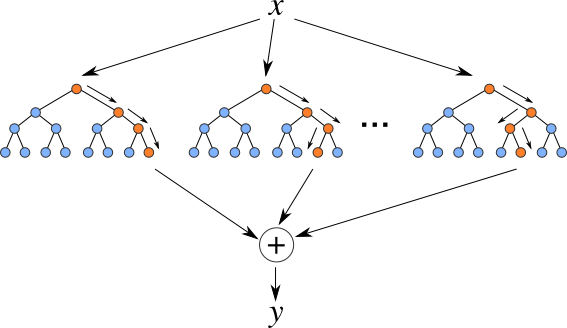

The diagram above shows the structure of a Random Forest. You can notice that the trees run in parallel with no interaction amongst them. A Random Forest operates by constructing several decision trees during training time and outputting the mean of the classes as the prediction of all the trees. To get a better understanding of the Random Forest algorithm, let’s walk through the steps:

1. Pick at random k data points from the training set.
2. Build a decision tree associated to these k data points.
3. Choose the number N of trees you want to build and repeat steps 1 and 2.

## d) Walk-forward validation for univariate data
Walk forward validation is an important step in this kind of data, specially if the data is continuously streaming in. We need a model that can cater for new data points while predicting the next data points. In this notebook, we perform a 12 point walk forward validation. 

In short we train our model on a specific amount of training data and predict the next 12 data points, after ths prediction the 12 predicted data points are then merged into the training data and next 12 data points are predicted. In this way we can take input from real time streaming data and add it to the process of predicting future values. 

# Functions-For-Processing

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
from numpy import asarray
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot

## Transform a time series dataset into a supervised learning dataset

This steps includes converting a naive time series data into a supervised dataset. The number of values to be used as lag for supervised dataset is sent as a parameter to the function. 


The function takes the original dataset and add columns infront of each data value. These columns are bascially the preceding values to that particular value, in the time series. 

In [2]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # put it all together
    agg = concat(cols, axis=1)
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg.values

## Split a univariate dataset into train/test sets

In [3]:
def train_test_split(data, n_test):
    return data[:-n_test, :], data[-n_test:, :]

## Fit an random forest model and make a one step prediction


In [4]:
def random_forest_forecast(train, testX):
    # transform list into array
    train = asarray(train)
    # split into input and output columns
    trainX, trainy = train[:, :-1], train[:, -1]
    # fit model
    model = RandomForestRegressor(n_estimators=100)
    model.fit(trainX, trainy)
    # make a one-step prediction
    yhat = model.predict([testX])
    return yhat[0]

## Walk-forward validation for univariate data


In [5]:
def walk_forward_validation(data, n_test):
    data = series_to_supervised(data, n_in=6)
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # split test row into input and output columns
        testX, testy = test[i, :-1], test[i, -1]
        # fit model on history and make a prediction
        yhat = random_forest_forecast(history, testX)
        # store forecast in list of predictions
        predictions.append(yhat)   
        # history.append(test[i]) # use only if: add actual observation to history for the next loop
        # summarize progress
        print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
    # estimate prediction error
    error = mean_absolute_error(test[:, -1], predictions)
    mse = mean_squared_error(test[:, -1], predictions)
    return error, test[:, -1], predictions, mse

# Processing-and-Evaluation

## Analysis-based-on-60-days-input-data

### load-the-60-day-dataset

,0
count,17274.000000
mean,129.411485
std,41.198385
min,39.000000
25%,102.000000
50%,122.000000
75%,150.000000
max,386.000000


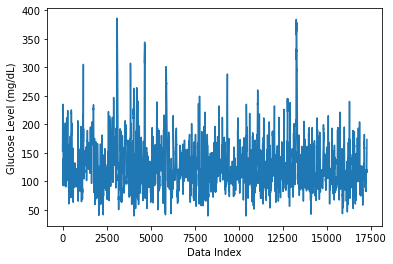

In [6]:
series = read_csv(
    r'C:\Users\ahtis\OneDrive\Desktop\ARIMA\data\data.csv', header=0, index_col=0)
values = series.values

# Read 60 days of data from the dataset for validation. Each datapoint is recorded with 5 minute interval in between.
# (12 points in an hour, 288 points in a day, 17280 in 60 days)

data = values[0:17280]
data1 = values[0:17280]
pyplot.plot(data, label='Glucose Data')

pyplot.xlabel('Data Index')
pyplot.ylabel('Glucose Level (mg/dL)')

data1 = pd.DataFrame(data)
data1.describe()

### Evaluate-for-60-days

>expected=118.0, predicted=120.1
>expected=118.0, predicted=117.5
>expected=119.0, predicted=118.3
>expected=120.0, predicted=118.6
>expected=116.0, predicted=120.5
>expected=118.0, predicted=114.1
>expected=119.0, predicted=117.5
>expected=117.0, predicted=118.3
>expected=118.0, predicted=114.5
>expected=115.0, predicted=119.3
>expected=115.0, predicted=113.8
>expected=117.0, predicted=113.5
>expected=126.0, predicted=118.2
>expected=127.0, predicted=128.4
>expected=133.0, predicted=126.1
>expected=136.0, predicted=137.1
>expected=139.0, predicted=138.8
>expected=150.0, predicted=141.0
>expected=156.0, predicted=154.6
>expected=162.0, predicted=161.3
>expected=165.0, predicted=167.5
>expected=167.0, predicted=167.7
>expected=171.0, predicted=167.7
>expected=173.0, predicted=172.9
MAE: 2.646
MSE: 12.659


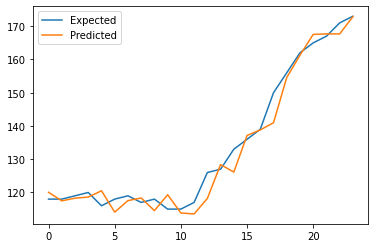

>expected=174.0, predicted=174.9
>expected=172.0, predicted=174.0
>expected=169.0, predicted=168.8
>expected=166.0, predicted=168.1
>expected=168.0, predicted=163.3
>expected=169.0, predicted=168.9
>expected=165.0, predicted=168.8
>expected=165.0, predicted=161.8
>expected=163.0, predicted=163.0
>expected=162.0, predicted=160.9
>expected=163.0, predicted=159.2
>expected=161.0, predicted=162.0
>expected=161.0, predicted=159.7
>expected=158.0, predicted=159.5
>expected=150.0, predicted=154.9
>expected=149.0, predicted=145.1
>expected=149.0, predicted=145.5
>expected=148.0, predicted=148.8
>expected=147.0, predicted=146.5
>expected=147.0, predicted=146.4
>expected=147.0, predicted=146.6
>expected=148.0, predicted=146.2
>expected=155.0, predicted=148.3
>expected=152.0, predicted=153.1
MAE: 2.083
MSE: 7.467


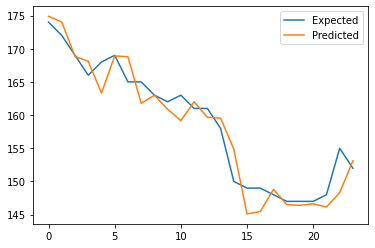

>expected=156.0, predicted=152.1
>expected=155.0, predicted=156.2
>expected=151.0, predicted=156.5
>expected=148.0, predicted=144.6
>expected=145.0, predicted=143.2
>expected=147.0, predicted=143.6
>expected=149.0, predicted=146.7
>expected=145.0, predicted=148.2
>expected=141.0, predicted=142.6
>expected=134.0, predicted=136.7
>expected=135.0, predicted=128.5
>expected=137.0, predicted=134.6
>expected=136.0, predicted=135.9
>expected=135.0, predicted=136.7
>expected=134.0, predicted=133.4
>expected=134.0, predicted=133.0
>expected=137.0, predicted=132.1
>expected=133.0, predicted=137.1
>expected=128.0, predicted=131.1
>expected=129.0, predicted=121.7
>expected=131.0, predicted=129.4
>expected=133.0, predicted=131.8
>expected=128.0, predicted=133.4
>expected=126.0, predicted=125.0
MAE: 2.901
MSE: 11.952


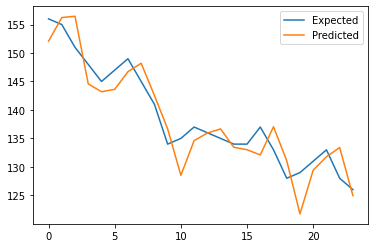

In [7]:
mean_abs_error = list()
for i in range(3):
    mae, y, yhat,mse = walk_forward_validation(data, 24)
    print('MAE: %.3f' % mae)
    print('MSE: %.3f' % mse)
    #data = values[len(data)-2:len(data)+len(data)-2, :]
    #yhat = np.asarray(yhat)
    # print('yhat',yhat.shape)
    #yhat_append = series_to_supervised(yhat, n_in=6)
    #print('yhat append',yhat_append.shape)
    #y_append = np.asarray(y)
    #data = np.append(data, y_append)
    #data = np.reshape(data, (-1, 1))
    data = values[0:len(data)+24,:]
    mean_abs_error.append(mae)
    pyplot.plot(y, label='Expected')
    pyplot.plot(yhat, label='Predicted')
    #pyplot.title('Loss: MAE = %f' % (mae) , 'Loss: MSE = %f' % (mse) )
    pyplot.legend()
    pyplot.show()

### Insight-for-60-days

Using the 60 Day time period for our data, we are able to iterate two time over the data set. Here we are predicting next 24 points which is next 2 hours of data. 

The Key Insight is that as we progress in the foward 24 step validation the MAE and MSE remains almost constant.

In first prediction the MAE is at 2.64 and MSE is at 12.6.

In second iteration the MAE is at 2.08 and MSE is at 7.4. 

In Third iteration the MAE is at 2.9 and MSE is at 11.9. 

Although there is increase but Model is considered to be useful if MAE is less than 10 in general, since the trend is maintained. Higher MAE can further distort the prediction as compared to original values. 

## Analysis-based-on-30-days-input-data

### Load the data

,0
count,8634.000000
mean,131.939889
std,44.110320
min,39.000000
25%,102.000000
50%,125.000000
75%,154.000000
max,386.000000


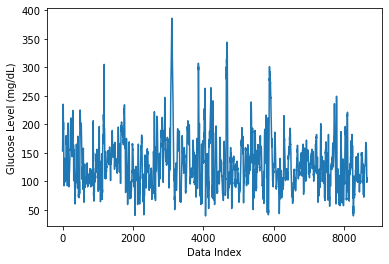

In [8]:
series = read_csv(
    r'C:\Users\ahtis\OneDrive\Desktop\ARIMA\data\data.csv', header=0, index_col=0)
values = series.values

# Read 60 days of data from the dataset for validation. Each datapoint is recorded with 5 minute interval in between.
# (12 points in an hour, 288 points in a day, 17280 in 60 days)

data = values[0:8640]
data1 = values[0:8640]
pyplot.plot(data, label='Glucose Data')

pyplot.xlabel('Data Index')
pyplot.ylabel('Glucose Level (mg/dL)')

data1 = pd.DataFrame(data)
data1.describe()

>expected=158.0, predicted=157.3
>expected=160.0, predicted=157.6
>expected=162.0, predicted=160.7
>expected=163.0, predicted=162.4
>expected=162.0, predicted=164.1
>expected=163.0, predicted=160.7
>expected=158.0, predicted=162.1
>expected=155.0, predicted=155.2
>expected=155.0, predicted=151.4
>expected=153.0, predicted=154.7
>expected=152.0, predicted=151.2
>expected=152.0, predicted=150.3
>expected=148.0, predicted=151.3
>expected=145.0, predicted=146.6
>expected=143.0, predicted=144.0
>expected=139.0, predicted=138.4
>expected=129.0, predicted=136.6
>expected=116.0, predicted=125.2
>expected=108.0, predicted=106.7
>expected=102.0, predicted=101.0
>expected=98.0, predicted=91.4
>expected=98.0, predicted=95.6
>expected=101.0, predicted=97.4
>expected=106.0, predicted=102.6
MAE: 2.624
MSE: 11.986


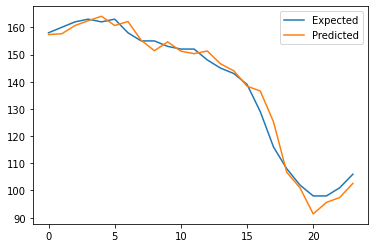

>expected=111.0, predicted=108.4
>expected=115.0, predicted=113.8
>expected=119.0, predicted=119.6
>expected=125.0, predicted=124.3
>expected=131.0, predicted=132.3
>expected=138.0, predicted=134.7
>expected=142.0, predicted=142.6
>expected=150.0, predicted=146.7
>expected=156.0, predicted=155.9
>expected=164.0, predicted=158.9
>expected=172.0, predicted=170.3
>expected=180.0, predicted=176.0
>expected=187.0, predicted=183.7
>expected=193.0, predicted=193.0
>expected=196.0, predicted=193.8
>expected=191.0, predicted=195.2
>expected=185.0, predicted=191.4
>expected=180.0, predicted=179.5
>expected=167.0, predicted=178.2
>expected=150.0, predicted=159.3
>expected=132.0, predicted=132.1
>expected=112.0, predicted=117.5
>expected=100.0, predicted=98.5
>expected=90.0, predicted=93.5
MAE: 3.010
MSE: 17.174


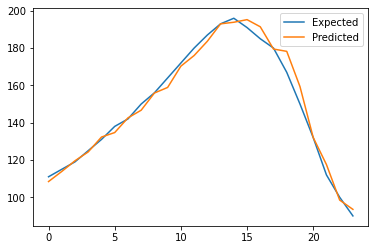

>expected=82.0, predicted=85.8
>expected=81.0, predicted=76.7
>expected=84.0, predicted=77.9
>expected=88.0, predicted=82.6
>expected=93.0, predicted=89.3
>expected=96.0, predicted=96.7
>expected=101.0, predicted=97.3
>expected=103.0, predicted=104.5
>expected=107.0, predicted=104.6
>expected=113.0, predicted=109.5
>expected=119.0, predicted=117.4
>expected=125.0, predicted=125.2
>expected=130.0, predicted=131.7
>expected=133.0, predicted=137.1
>expected=137.0, predicted=136.0
>expected=139.0, predicted=139.7
>expected=142.0, predicted=141.9
>expected=143.0, predicted=144.9
>expected=145.0, predicted=144.8
>expected=143.0, predicted=145.6
>expected=142.0, predicted=139.8
>expected=138.0, predicted=138.6
>expected=134.0, predicted=136.0
>expected=126.0, predicted=131.2
MAE: 2.462
MSE: 9.046


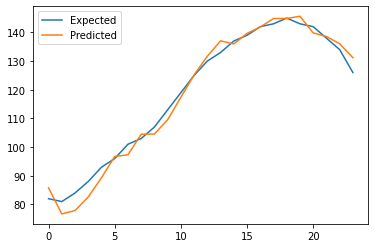

In [9]:
mean_abs_error = list()
for i in range(3):
    mae, y, yhat, mse = walk_forward_validation(data, 24)
    print('MAE: %.3f' % mae)
    print('MSE: %.3f' % mse)
    #data = values[len(data)-2:len(data)+len(data)-2, :]
    #yhat = np.asarray(yhat)
    # print('yhat',yhat.shape)
    #yhat_append = series_to_supervised(yhat, n_in=6)
    #print('yhat append',yhat_append.shape)
    #y_append = np.asarray(y)
    #data = np.append(data, y_append)
    #data = np.reshape(data, (-1, 1))
    data = values[0:len(data)+24,:]
    mean_abs_error.append(mae)
    pyplot.plot(y, label='Expected')
    pyplot.plot(yhat, label='Predicted')
   # pyplot.title('Loss: MAE = %f' % (mae) ,'Loss: MSE = %f' % (mse))
    pyplot.legend()
    pyplot.show()

### Insight

Using the 30 Day time period for our data, we are able to iterate four times over the data set. Here we are predicting next 24 points which is next 2 hour of data. 

The Key Insight is that as we progress in the foward 24 step validation the MAE and MSE almost remains constant.

In first iteration the MAE is at 2.6 and MSE is at 11.9.

In second iteration the MAE is at 3.0 and MSE is at 17.1. 

In third iteration the MAE is at 2.4 and MSE is at 9.0. 


Although there is increase in error but Model can be considered to be useful until third iteration, since the trend is maintained. Higher MAE can further distort the prediction as compared to original values. 

# Summary

If we increase the number of iterations the MAE and MSE is almost constant with slight up and down variations based on that. The model is behaving good in terms of accuracy and is able to capture good predic

## Suggestions

1. Increasing the input dataset may(not necessarily) decrease the overall error rate.
2. Model is performing good enough and can be deployed in a practical scenario on test trials for further evaluation. 

